In [175]:
library(scales)
library(data.table)
library(tidyr)

In [2]:
setwd('/nfs/lab/projects/pbmc_snATAC/analysis_v2/anova_interaction/')

In [19]:
maindir     = '/nfs/lab/projects/pbmc_snATAC/analysis_v2/rasqual_eur/fine/'
fine   = list.files(maindir)[!grepl(".txt", list.files(maindir))]


In [21]:
broad = c("b", "t", "mono", "nk")

In [3]:
longf     = read.table('../summarized_caqtls/run3/EUR_caqtl_leads_run3.tsv', header=T)
genotypes = read.table("All_tested_genotypes.tsv", header=T)

In [6]:
longf = subset(longf, cell != "bulk" & exclude== FALSE)

In [201]:
signif = subset(longf, flag_fdr10==T)

In [202]:
ag = aggregate(Feature~cell,signif, length)

In [204]:
mean(ag$Feature)

[1] 805.5789

In [8]:
AF = rowSums(genotypes)/ 20

In [217]:
MAF = sapply(AF, function (x) min(x, 1-x))

In [218]:
summary(MAF)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.1000  0.1500  0.2500  0.2633  0.3500  0.5000 

In [11]:
longf$AF = AF[longf$varID]

In [220]:
longf$MAF = MAF[longf$varID]

In [41]:
longf$abseffect = abs(longf$Effect_size-0.5)

In [43]:
main      = '/nfs/lab/projects/pbmc_snATAC/analysis_v2/rasqual_eur/'

In [45]:
cells = data.frame(celltypes = c(broad, fine), type = c( rep("broad", 4), rep("fine", 15)))

In [47]:
dim(cells)

[1] 19  2

In [53]:
avcov_list = list()
for (i in 1:19){

ce    =   as.character(cells[i,1])  
home  =   paste0(main, as.character(cells[i,2]), "/"  )    
peaks =   read.table(paste0(home, ce,"/",ce, ".count_matrix" ), header=T, stringsAsFactors = F, row.names = 1)

avcov_list[[ce]] = rowMeans(peaks[,6:15])
}

In [78]:
test =vector(mode='numeric',length = nrow(longf) )

In [131]:
for (i in c(broad, fine)){
test[longf$cell==i] <- avcov_list[[i]][longf$Feature[longf$cell==i]]
    }

In [132]:
longf$average_coverage = test

In [15]:
wide10 = spread(data = longf[,c('Feature', 'cell', 'flag_fdr10')], key=cell, value =flag_fdr10 )
wide5 = spread(data = longf[,c('Feature', 'cell', 'flag_fdr05')], key=cell, value =flag_fdr05 )
wide1 = spread(data = longf[,c('Feature', 'cell', 'flag_fdr01')], key=cell, value =flag_fdr01 )

In [157]:
resolution = broad

In [150]:
resolution = fine

In [158]:
stats = c(sum(rowSums(wide10[,resolution], na.rm=T) ==1),
            sum(rowSums(wide5[,resolution], na.rm=T) ==1),
            sum(rowSums(wide1[,resolution], na.rm=T) ==1),
            sum(rowSums(wide10[,resolution], na.rm=T) >1),
            sum(rowSums(wide5[,resolution], na.rm=T) >1),
            sum(rowSums(wide1[,resolution], na.rm=T) >1))

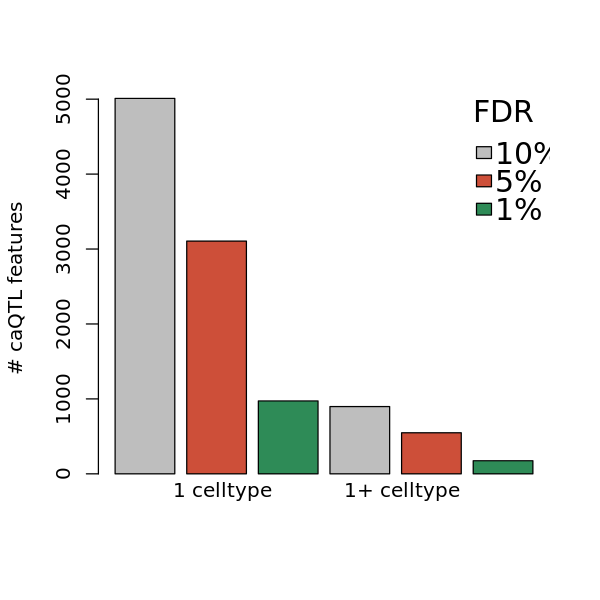

In [159]:
options(repr.plot.width=5, repr.plot.height=5)
col = c("gray","tomato3", "seagreen")
barplot(stats, col = col, ylab = "# caQTL features")
legend("topright", fill = col, legend = c("10%", "5%", "1%"), bty="n", title= "FDR",
       cex=1.5,x.intersp = 0.2,y.intersp = 1.2)
mtext("1 celltype", at =2, side=1)
mtext("1+ celltype", at =5, side=1)

In [160]:
stats = stats[c(1,4,2,5,3,6)]

In [223]:
longsub = subset(longf, cell %in% resolution )
longsub$N_celltypes = ifelse(test = longsub$Feature %in% wide10[,1][rowSums(wide10[,resolution], na.rm=T) >1],
                       yes = ">1", no="1" )
longsub$N_celltypes[longsub$flag_fdr10==FALSE]<- "not_sig"

In [224]:
longsub$N_celltypes[longsub$N_celltypes == 'not_sig']<- "NS"

In [155]:
colors = c("orange", "steelblue", "gray")
tests = c('AF', 'abseffect', 'average_coverage')
pdf("../figures/Compare_shared_andPrivate_fine.pdf", height = 3, width = 8)
par (mfrow=c(1,4))
barplot(stats, col = c( "steelblue","orange"),  ylab = "# caQTL features", xlab="FDR",
        names.arg = rep(c("10%", "5%", "1%"),each=2))
legend("topright", fill = c( "steelblue","orange"), legend = c("1 celltype", ">1 celltype"), bty="n", 
       cex=1.1,x.intersp = 0.2,y.intersp = 1.2)


for (x in 1:3){
boxplot( as.formula(paste(tests[x], '~N_celltypes')), longsub, col=colors, outline=F)
pv = signif (wilcox.test(longsub[ longsub$N_celltypes=="1" , tests[x]]  ,
                         longsub[ longsub$N_celltypes==">1" , tests[x]] )$p.value, 3)
mtext(paste("p=", pv), at = 1.5, cex = 0.8)
    }
dev.off()

png 
  2

In [195]:
tests = c('AF', 'abseffect', 'average_coverage','Ref_allele_bias','Sequencing_mapping_error_rate' )
pdf("../figures/Compare_shared_andPrivate_broad_add.pdf", height = 3, width = 8)
par (mfrow=c(1,5))

for (x in 1:5){
boxplot( as.formula(paste(tests[x], '~N_celltypes')), longsub, col=colors, outline=F)
pv = signif (wilcox.test(longsub[ longsub$N_celltypes=="1" , tests[x]]  ,
                         longsub[ longsub$N_celltypes==">1" , tests[x]] )$p.value, 3)
mtext(paste("p=", pv), at = 1.5, cex = 0.8)
    }
dev.off()

png 
  2

### Broad

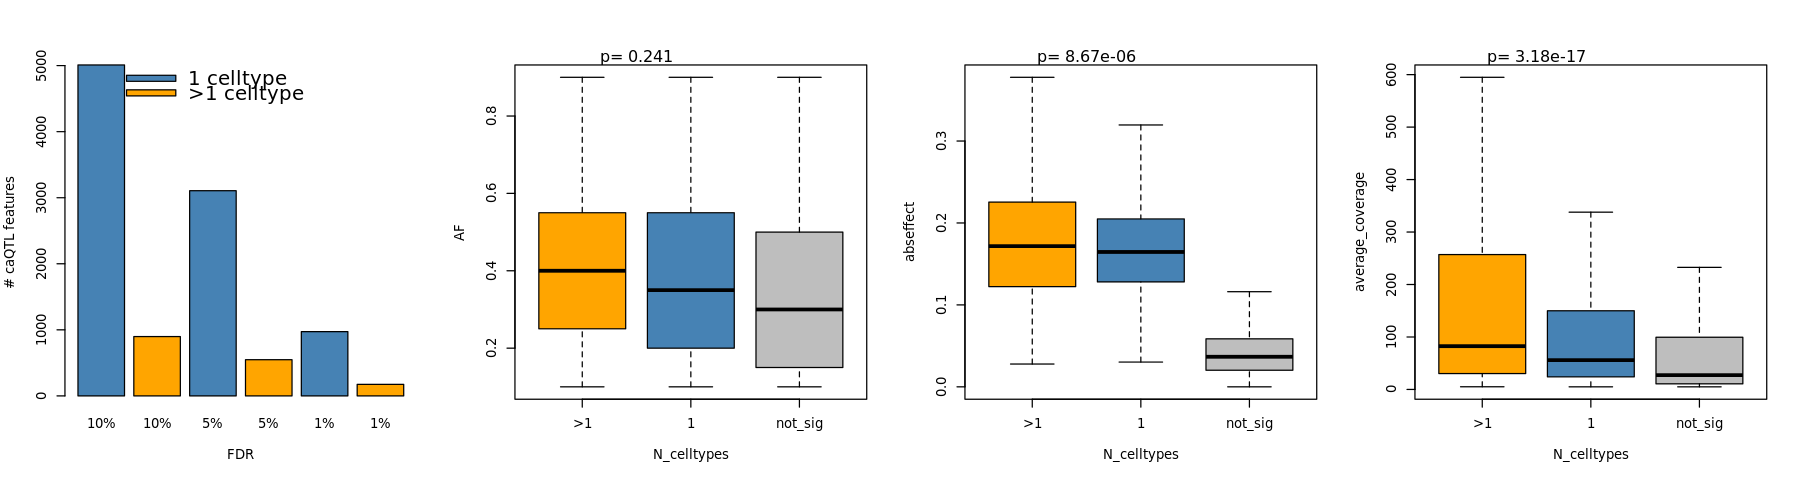

In [206]:
options(repr.plot.width=15, repr.plot.height=4)

par (mfrow=c(1,4))
barplot(stats, col = c( "steelblue","orange"),  ylab = "# caQTL features", xlab="FDR",
        names.arg = rep(c("10%", "5%", "1%"),each=2))
legend("topleft", fill = c( "steelblue","orange"), legend = c("1 celltype", ">1 celltype"), bty="n", 
       cex=1.5,x.intersp = 0.2,y.intersp = 1.2)


for (x in 1:3){
boxplot( as.formula(paste(tests[x], '~N_celltypes')), longsub, col=colors, outline=F)
pv = signif (t.test(longsub[ longsub$N_celltypes=="1" , tests[x]]  ,
                         longsub[ longsub$N_celltypes==">1" , tests[x]] )$p.value, 3)
mtext(paste("p=", pv), at = 1.5, cex = 0.8)
    }


In [221]:
tests = c('MAF', 'abseffect', 'average_coverage','Ref_allele_bias','Sequencing_mapping_error_rate' )

In [225]:
#options(repr.plot.width=10, repr.plot.height=10)
pdf("../figures/Compare_shared_andPrivate_broad_percelltype_ttest.pdf", height = 10, width = 8)

par(mfrow=c(4,5), mar = c(4,4,4,1))
for (y in resolution){
    subsub = subset(longsub, cell ==y)
for (x in 1:5){
boxplot( as.formula(paste(tests[x], '~N_celltypes')), subsub, col=colors, outline=F, main = y)
pv = signif (t.test(subsub[ subsub$N_celltypes=="1" , tests[x]]  ,
                         subsub[ subsub$N_celltypes==">1" , tests[x]] )$p.value, 3)
mtext(paste("p=", pv), at = 1.5, cex = 0.8)
    }
}
dev.off()

png 
  2

In [165]:
spp = split(longsub, longsub$cell)

In [172]:
privatqtls = lapply(spp, function(x) x$Feature[x$N_celltypes=="1"])

In [171]:
sumdir = "/nfs/lab/projects/pbmc_snATAC/analysis_v2/summarized_caqtls/run3/"

In [174]:
cormat = matrix(NA, ncol=4 , nrow=4)
rownames(cormat)= colnames(cormat) = resolution

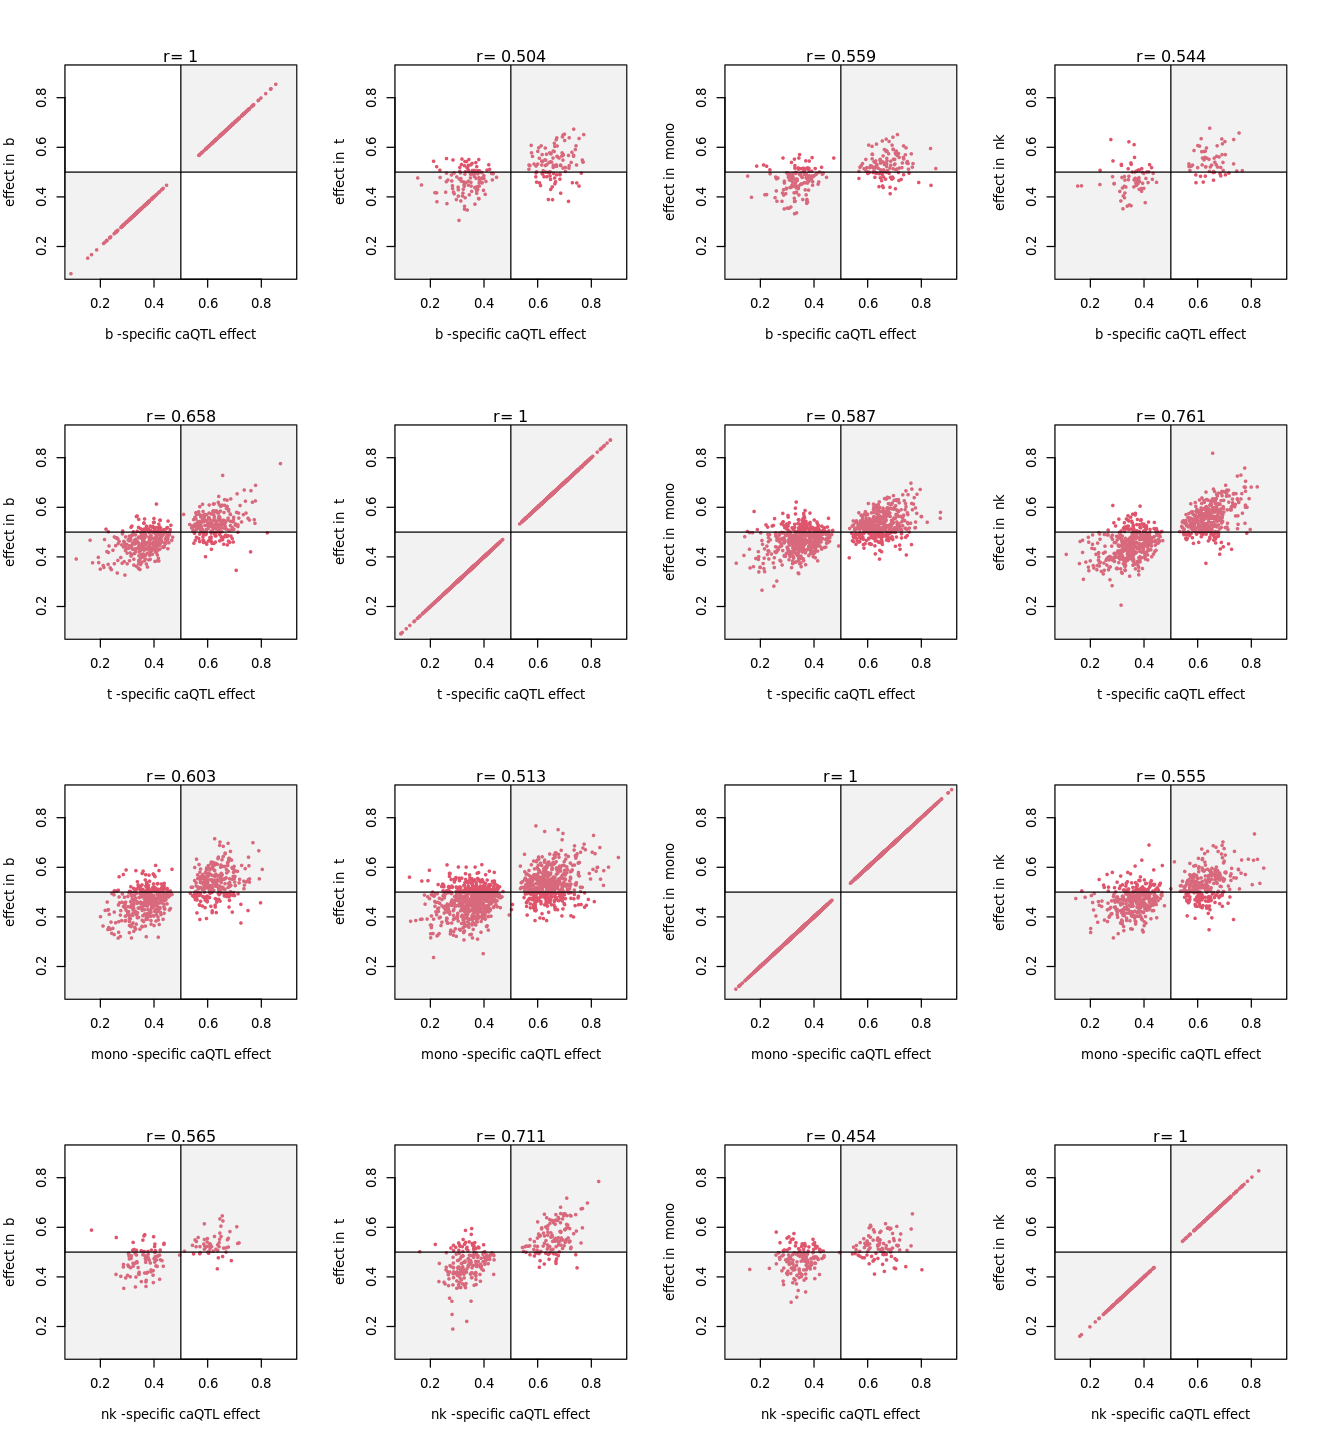

In [184]:
options(repr.plot.width=11, repr.plot.height=12)
par(mfrow=c(4,4))
for(c1 in resolution){
a = fread(paste0(sumdir, c1, "_caqtl_sumstats_run3.tsv"), header=T)
a$feature_snp = paste(a$Feature, a$varID, sep="_")    
    for(c2 in resolution){


b = fread(paste0(sumdir, c2, "_caqtl_sumstats_run3.tsv"), header=T)
b$feature_snp = paste(b$Feature, b$varID, sep="_")

m = merge(a[,c('feature_snp',"Feature","P_value" ,'Effect_size', 'Is_peak_caQTL')] , 
          b[,c('feature_snp','Effect_size',"P_value", 'Is_peak_caQTL')], by="feature_snp")

m      = subset(m, Feature %in% privatqtls[[c1]])
m$minP = apply(m[,c("P_value.x", "P_value.y")],1,min)
m      = m[order(m$minP),]
m      = m [!duplicated(m$Feature),]

cormat[c1,c2] = suppressWarnings(cor.test(m$Effect_size.x, m$Effect_size.y, method = "spearman")$estimate)
 plot(Effect_size.y~ Effect_size.x, m, pch=20, cex = 0.6,    col=2, xlim=c(0.1,0.9),ylim=c(0.1,0.9),
      xlab = paste(c1, "-specific caQTL effect") , ylab= paste("effect in ",c2) )
 rect(0,0,0.5,0.5, col = alpha ('gray', 0.2))
 rect(0.5,0.5,1,1, col = alpha ('gray', 0.2))
mtext(paste("r=", round(cormat[c1,c2], 3)), cex=0.8)
        
        }
    }

### FIne

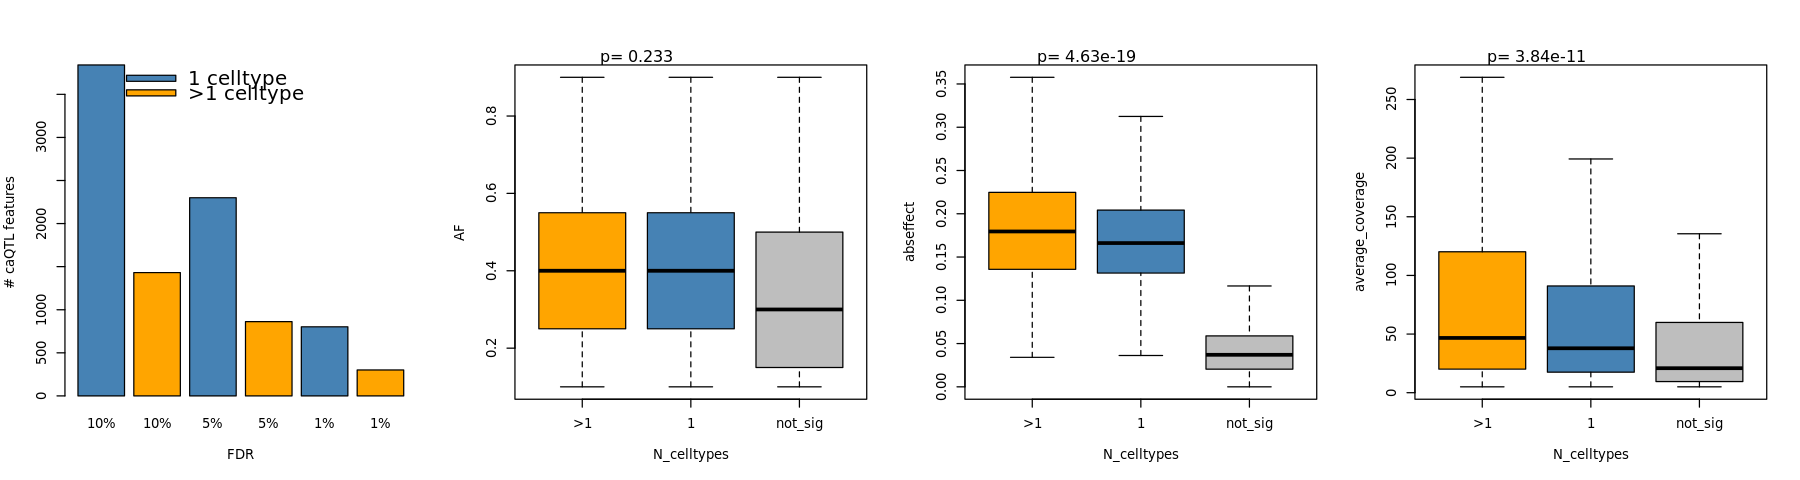

In [156]:
options(repr.plot.width=15, repr.plot.height=4)

par (mfrow=c(1,4))
barplot(stats, col = c( "steelblue","orange"),  ylab = "# caQTL features", xlab="FDR",
        names.arg = rep(c("10%", "5%", "1%"),each=2))
legend("topleft", fill = c( "steelblue","orange"), legend = c("1 celltype", ">1 celltype"), bty="n", 
       cex=1.5,x.intersp = 0.2,y.intersp = 1.2)


for (x in 1:3){
boxplot( as.formula(paste(tests[x], '~N_celltypes')), longsub, col=colors, outline=F)
pv = signif (wilcox.test(longsub[ longsub$N_celltypes=="1" , tests[x]]  ,
                         longsub[ longsub$N_celltypes==">1" , tests[x]] )$p.value, 3)
mtext(paste("p=", pv), at = 1.5, cex = 0.8)
    }
